Hip Dysplasia Classification

v4 - Experiment One - Based on code from ...


Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time
import numpy as np 
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from data_loader import DataGenerator
from models import resnet2

Model Architecture is a ResNET

In [2]:
def resnet2(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS):

    he_init = keras.initializers.he_normal(seed=None)

    def res_net_block(input_data, filters, kernel_size, strides=1):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu', kernel_initializer=he_init)(input_data)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, kernel_size, padding='same', activation=None, kernel_initializer=he_init)(x)
        x = layers.BatchNormalization()(x)
        
        if(strides == 2):  # add linear projection residual shortcut connection to match changed dims
            input_data = layers.Conv2D(filters, 1, strides=strides, padding='same', activation=None, kernel_initializer=he_init)(input_data)
        x = layers.Add()([x, input_data])
        x = layers.Activation('relu')(x)
        return x

    inputs = keras.Input(shape=(HEIGHT, WIDTH, CHANNELS))
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=he_init)(inputs)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he_init)(x)
    x = layers.MaxPooling2D(3)(x)

    num_filters = 64
    for stage in range(3):
        if(stage == 0):
            x = res_net_block(x, num_filters, 3)
        else:
            x = res_net_block(x, num_filters, 3, strides=2)
        x = res_net_block(x, num_filters, 3)
        x = res_net_block(x, num_filters, 3)
        x = res_net_block(x, num_filters, 3)
        x = res_net_block(x, num_filters, 3)
        num_filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1000, activation='relu', kernel_initializer=he_init)(x)
    outputs = layers.Dense(NUM_OUTPUTS, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    layer_count = sum([model.layers[i].name.count('conv') for i in range(len(model.layers))])
    print("Number of conv layers in the model: ", layer_count)
    return model

Parameters

In [3]:
# Training Parameters
epochs = 200
batch_size = 128 

# Network Parameters
useTransferLearning = False
WIDTH = 256
HEIGHT = 256
CHANNELS = 3 if useTransferLearning else 1 
NUM_OUTPUTS = 2

Training 

In [4]:
'''
Trains model using input dataset. Currently uses Adam optimizer, and early stopping in training. Outputs model, train_history, and test metrics
'''
def TrainResNet(dataset):

    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1, patience=25)

    model = resnet2(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS)
    model.compile(optimizer=keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['acc'])
    model.summary()
    
    # Train and Evaluate model
    training_steps = round(data.train_size / batch_size)
    validation_steps = round(data.test_size / batch_size)
    train_history = model.fit(dataset.train_dataset, epochs=epochs, steps_per_epoch=training_steps,
            validation_data=dataset.valid_dataset,
            validation_steps=validation_steps,
            callbacks=[earlyStopping])
    
    # Evaluate Test Data 
    steps = round(data.test_size / (batch_size))
    test_metrics = model.evaluate(dataset.test_dataset, batch_size=batch_size, steps=steps)
    
    return model, train_history, test_metrics
    

Ploting and Saving

In [5]:
'''
Plots metric history data for training a model 
'''
def plot(data, model_name, summary):
    # Plot Accuracy / Loss 
    fig, axs = plt.subplots(2)
    fig.suptitle(model_name + ': ' + summary)

    axs[0].plot(data[0].history['acc'])
    axs[0].plot(data[0].history['val_acc'])
    axs[0].set_ylabel('acc')
    axs[0].legend(["Train", "Test"], loc="lower right")

    axs[1].plot(data[0].history['loss'])
    axs[1].plot(data[0].history['val_loss'])
    axs[1].set_ylabel('loss')
    axs[1].legend(["Train", "Test"], loc="upper right")
    
    #plt.show()
    plt.savefig('hip_classify_' + model_name +'.png')

'''
Saves training and test metrics to metrics.npy
'''
def load_and_save(model_name, history, metrics):
    fname = 'metrics.npy' 
    fileExists = os.path.isfile(fname)
    if(fileExists):
        data = np.load(fname, allow_pickle=True)[()]
        data[model_name] = { 'train_history': history.history, 'test_metrics': metrics }
    else:
        data = { model_name: { 'train_history': history.history, 'test_metrics': metrics } }
    
    np.save(fname, data)

Run Training and Plot Results

In [6]:
imagedir = '../../../../data/hip_images_marta/'
csvfilename = '../../../../data/hip_images_marta/final_data.csv'

# Generate datasets 
data = DataGenerator(width=WIDTH, height=HEIGHT, channels=CHANNELS, imagedir=imagedir, csvfilename=csvfilename, batch_size=batch_size)
print('Train Size: ' + str(data.train_size) + ' Test Size: ' + str(data.test_size))
    
# Train model 
print("Training ResNet2 ...")
start = time.time()
model, train_history, test_metrics = TrainResNet(data)
end = time.time()


  3%|██▎                                                                            | 31/1079 [00:00<00:03, 298.79it/s]

Loading and formating image data ....


100%|██████████████████████████████████████████████████████████████████████████████| 1079/1079 [00:37<00:00, 28.98it/s]


Training data size: Input Data (863, 500, 500, 1)  Truth Data: (863, 2)
Test data size: Input Data (216, 500, 500, 1)  Truth Data: (216, 2)
Loading and formating image data: Complete
Train Size: 863 Test Size: 216
Training ResNet2 ...
Number of conv layers in the model:  34
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 18496       conv2d[0][0]                     
_________________

ResNet: Loss: 0.001917, Accuracy: 1.000000, Time: 530.39s


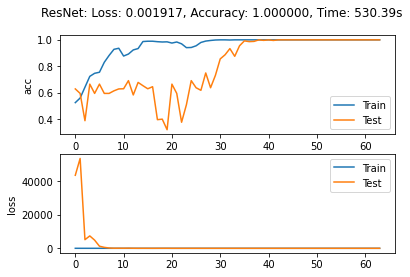

In [7]:
# Plot and Output results
summary = 'Loss: %.6f, Accuracy: %.6f, Time: %.2fs' % (test_metrics[0], test_metrics[1], (end - start))
print('ResNet: ' + summary)
plot([train_history], 'ResNet', summary)

# Save train_history and test_metrics
test_metrics = { 'loss': test_metrics[0], 'acc': test_metrics[1], 'time': (end - start) }
load_and_save('ResNet', train_history, test_metrics)

# Save model
import datetime
file_time = datetime.datetime.today().strftime('_%Y-%m-%d__%I-%M')
model.save('v4_resnet_keras_' + file_time + '.h5', save_format='tf')